In [1]:
import torch
import copy
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
 
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
green_dir1 = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\green1'
green_dir2 = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\green2'
yellow_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\yellow'
red_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\red'
blue_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\blue'

green_set1 = datasets.ImageFolder(
    green_dir1,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

green_set2 = datasets.ImageFolder(
    green_dir2,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

yellow_set = datasets.ImageFolder(
    yellow_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)
red_set = datasets.ImageFolder(
    red_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)
blue_set = datasets.ImageFolder(
    blue_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)


train_set1, test_set1 = torch.utils.data.random_split(green_set1, [250, 50])
train_set2, test_set2 = torch.utils.data.random_split(green_set2, [250, 50])
test_set = test_set1 + test_set2

normal_set = green_set1 + green_set2
abnormal_set = red_set + yellow_set + blue_set

In [15]:
def plot_graph(x, x_list, ylabel='Loss'):
    plt.plot(x, label='Fed Rai-Facto')
    if len(x_list) == 2:
        plt.plot(x_list[0], label='Client1')
        plt.plot(x_list[1], label='Client2')
    else:
        plt.plot(x_list, label='Conventional method')
        
    plt.xlabel('Round')
    plt.ylabel('Loss') if ylabel=='Loss' else plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


def plot_loss_zoom(round_loss, round_client_losses=None):
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
    ax = plt.subplot(1,1,1)
    ax.plot(round_loss, label='Avg')
    ax.set_xlabel('Round')
    ax.set_ylabel('Loss')
    if round_client_losses != None:
        ax.plot(np.array(round_client_losses)[0], label='Client1')
        ax.plot(np.array(round_client_losses)[1], label='Client2')
    ax.grid()
    ax.legend()

    axins = inset_axes(ax, 1.0, 0.8, loc = 1, bbox_to_anchor=(0.6, 0.75), bbox_transform = ax.figure.transFigure)
    
    axins.plot(round_loss, label = 'Avg')
    if round_client_losses != None:
        axins.plot(np.array(round_client_losses)[0], label = 'Client1')
        axins.plot(np.array(round_client_losses)[1], label = 'Client2')
    axins.set_xlim((0, 50))
    axins.set_ylim((0, 0.01))
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec = "0.4")

    plt.show()

In [4]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size = 2, stride = 2, padding=0),
            nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)      
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        
        return output

In [5]:
def load_data(): 
    ldt_loss = pd.read_csv(f"Loss/loss.csv")
    ldt_client_losses = pd.read_csv(f"Loss/client_losses.csv")
    ldt_acc = pd.read_csv(f"Acc/acc.csv")
    ldt_client_acces = pd.read_csv(f"Acc/client_acces.csv")

    ldt_loss, ldt_client_losses = np.delete(ldt_loss.values, 0, 1), np.delete(ldt_client_losses.values, 0, 1)
    ldt_client_loss1, ldt_client_loss2 = ldt_client_losses[0,:], ldt_client_losses[1,:]

    ldt_acc, ldt_client_acces = np.delete(ldt_acc.values, 0, 1), np.delete(ldt_client_acces.values, 0, 1)
    ldt_client_acc1, ldt_client_acc2 = ldt_client_acces[0,:], ldt_client_acces[1,:]

    return ldt_loss, ldt_client_loss1, ldt_client_loss2, ldt_acc, ldt_client_acc1, ldt_client_acc2

In [6]:
round_loss, client_loss1, client_loss2, round_acc, client_acc1, client_acc2 = load_data()
print(round_loss.shape, client_loss1.shape, client_loss2.shape)
print(round_acc.shape, client_acc1.shape, client_acc2.shape)

(300, 1) (300,) (300,)
(300, 1) (300,) (300,)


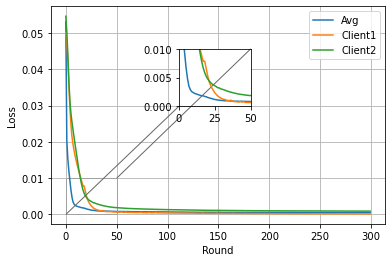

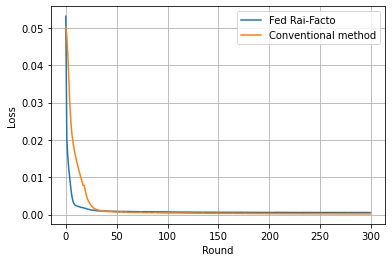

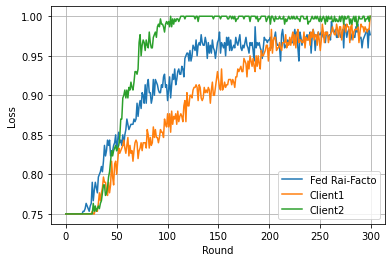

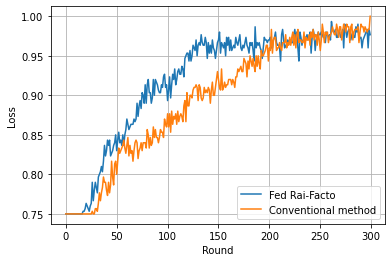

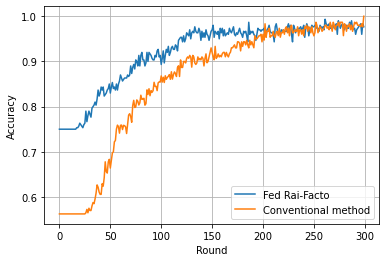

In [16]:
plot_loss_zoom(round_loss, [client_loss1, client_loss2])
plot_graph(round_loss, client_loss1)
plot_graph(round_acc, [client_acc1, client_acc2])
plot_graph(round_acc, client_acc1)


multiply_acces = np.multiply(client_acc1, client_acc2)
plot_graph(round_acc, multiply_acces, ylabel='Accuracy')

In [35]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.num_epochs = 5
args.num_rounds = 300
args.num_clients = 2
args.lr = 0.00001

args.batch_size = 1

args.NET_PATH = ''
args.INIT_PATH = f'model_per_round/round_{args.num_rounds}_weight.pth'

## **Round=5**

Normal loss: 0.009303060130526623
Abnormal loss: 0.013863198591603173


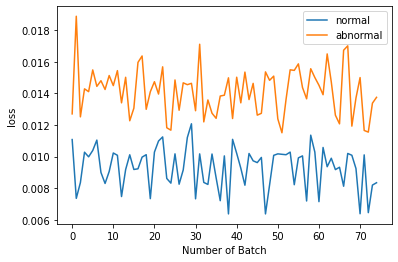

In [13]:
model = ConvAutoEncoder()
model = torch.load('model_per_round/round_5_weight.pth')
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=args.batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')


plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()

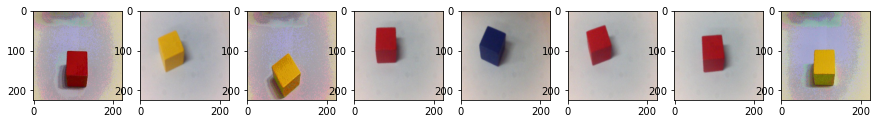

0.020890358835458755
0.011092404834926128
0.018210945650935173
0.013506101444363594
0.008688779547810555
0.013214509934186935
0.01383981853723526
0.016646625474095345


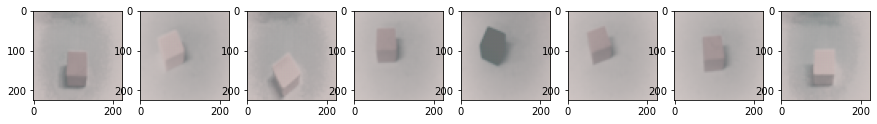

In [14]:
abnormal_images, abnormal_labels = next(iter(abnormal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(8), abnormal_images, abnormal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()



model.cpu()
abnormal_output = model(abnormal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(8), abnormal_output, abnormal_labels):
    loss = criterion(img, abnormal_images[i])
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()

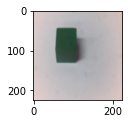

0.00011462085967650637


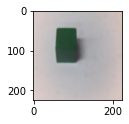

In [49]:
normal_images, normal_labels = next(iter(normal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(1), normal_images, normal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()


model.cpu()
normal_output = model(normal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(1), normal_output, normal_labels):
    loss = criterion(img, normal_images[i])
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()

## **Round=300**

Normal loss: 0.0005280801607295871
Abnormal loss: 0.0013989131970124113


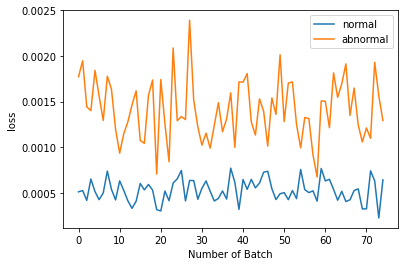

In [16]:
model = ConvAutoEncoder()
model = torch.load('model_per_round/round_300_weight.pth')
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=args.batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')


plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()

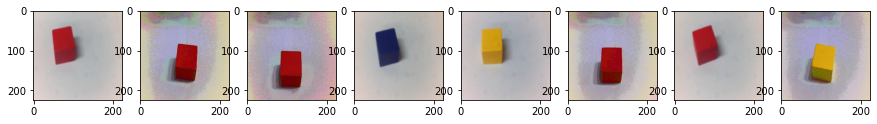

0.0011066666338592768
0.0031075032893568277
0.003052453277632594
0.00035215416573919356
0.0005329066189005971
0.0028683391865342855
0.001089679659344256
0.001556612434796989


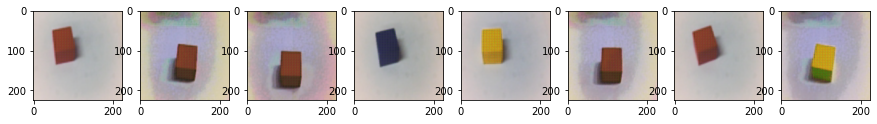

In [17]:
abnormal_images, abnormal_labels = next(iter(abnormal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(8), abnormal_images, abnormal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()



model.cpu()
abnormal_output = model(abnormal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(8), abnormal_output, abnormal_labels):
    loss = criterion(img, abnormal_images[i])
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()

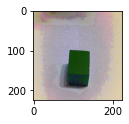

0.0008967209723778069


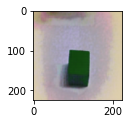

In [51]:
normal_images, normal_labels = next(iter(normal_loader))

fig = plt.figure(figsize=(15,3))

for i, img, label in zip(range(1), normal_images, normal_labels):
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()


model.cpu()
normal_output = model(normal_images)

fig = plt.figure(figsize=(15,3))
for i, img, label in zip(range(1), normal_output, normal_labels):
    loss = criterion(img, normal_images[i])
    print(loss.item())
    
    numpy_img = np.transpose(img.detach().numpy(), (1, 2, 0))
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(numpy_img)
plt.show()

## **Each Client**

Normal loss: 0.0013358147298761953
Abnormal loss: 0.003870297086218165


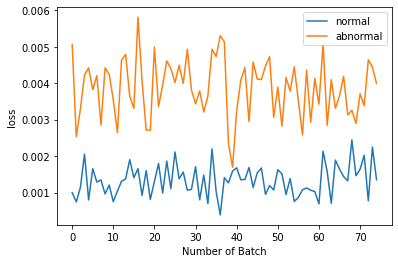

In [139]:
model = ConvAutoEncoder()
model = torch.load(f'each_model/model1.pth')
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=args.batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')


plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()

Normal loss: 0.000579554884073635
Abnormal loss: 0.0022228552064754896


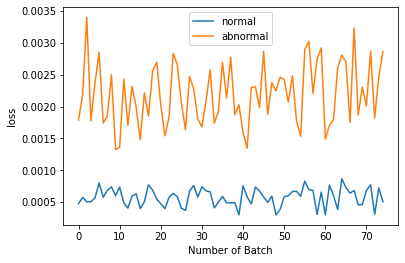

In [140]:
model = ConvAutoEncoder()
model = torch.load(f'each_model/model2.pth')
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(normal_set, batch_size=args.batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')


plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()

Normal loss: 0.00011041931353056019
Abnormal loss: 0.00150989061454311


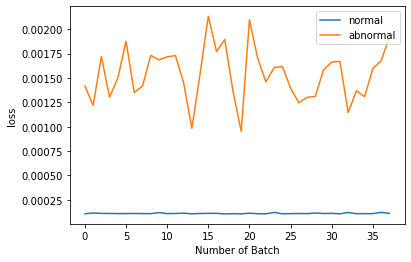

In [141]:
model = ConvAutoEncoder()
model = torch.load('model_per_round/round_300_weight.pth')
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(green_set1, batch_size=args.batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')


plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()

Normal loss: 0.0009493382577171648
Abnormal loss: 0.0015098906186823216


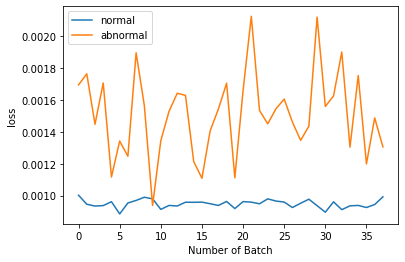

In [142]:
model = ConvAutoEncoder()
model = torch.load('model_per_round/round_300_weight.pth')
model.eval()

criterion = nn.MSELoss()

normal_loss = 0
normal_losses = []

abnormal_loss = 0
abnormal_losses = []

normal_loader = torch.utils.data.DataLoader(green_set2, batch_size=args.batch_size, shuffle=True)
abnormal_loader = torch.utils.data.DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

for i, (normal_img, _) in enumerate(normal_loader):
    normal_img = normal_img.to(device)
    
    normal_outputs = model(normal_img)
    loss = criterion(normal_outputs, normal_img)
    normal_loss += loss.item()
    normal_losses.append(loss.item())
    
print(f'Normal loss: {normal_loss/len(normal_loader)}')
    
for i, (abnormal_img, _) in enumerate(abnormal_loader):   
    abnormal_img = abnormal_img.to(device)
    
    abnormal_outputs = model(abnormal_img)
    loss = criterion(abnormal_outputs, abnormal_img)
    abnormal_loss += loss.item()
    abnormal_losses.append(loss.item())
    
print(f'Abnormal loss: {abnormal_loss/len(abnormal_loader)}')


plt.plot(normal_losses, label = 'normal')
plt.plot(abnormal_losses[:len(normal_loader)], label = 'abnormal')
plt.xlabel('Number of Batch')
plt.ylabel('loss')
plt.legend()
plt.show()